In [1]:
import os
import csv
import random
import shutil
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


In [9]:
import os

try:
    os.chdir(r"C:\Users\Eda EROL\OneDrive\veriseti")
    print("Yeni Dizin:", os.getcwd())

except FileNotFoundError:
    print("HATA: Belirtilen dizin bulunamadı.")



Yeni Dizin: C:\Users\Eda EROL\OneDrive\veriseti


In [10]:
import os
import shutil

src_dirs = ["HAM10000_images_part_1", "HAM10000_images_part_2"]
dst_dir = "all_images"


os.makedirs(dst_dir, exist_ok=True)


for folder in src_dirs:
    folder_path = os.path.join(os.getcwd(), folder)
    for file in os.listdir(folder_path):
        src_path = os.path.join(folder_path, file)
        dst_path = os.path.join(dst_dir, file)
        if not os.path.exists(dst_path):
            shutil.copy(src_path, dst_path)

print(f"Tüm görüntüler '{dst_dir}' klasöründe toplandı. Toplam: {len(os.listdir(dst_dir))} dosya")


Tüm görüntüler 'all_images' klasöründe toplandı. Toplam: 6680 dosya


In [11]:
import csv

metadata_file = "HAM10000_metadata.csv"
metadata = []

with open(metadata_file, newline="", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        metadata.append(row)

print(f"Metadata yüklendi. Toplam satır: {len(metadata)}")


Metadata yüklendi. Toplam satır: 10015


In [12]:
label_map = {
    "akiec": 0,
    "bcc": 1,
    "bkl": 2,
    "df": 3,
    "mel": 4,
    "nv": 5,
    "vasc": 6
}

data_list = []

for item in metadata:
    img_id = item["image_id"]
    label = label_map[item["dx"]]
    img_path = os.path.join(dst_dir, img_id + ".jpg")
    if os.path.exists(img_path):
        data_list.append((img_path, label))

print(f"Toplam kullanılabilir veri: {len(data_list)}")


Toplam kullanılabilir veri: 6680


In [13]:
import random


class_groups = {i: [] for i in range(7)}
for path, label in data_list:
    class_groups[label].append((path, label))

train_list, val_list, test_list = [], [], []

for label, items in class_groups.items():
    random.shuffle(items)
    n = len(items)
    test_n = int(n * 0.15)
    val_n = int(n * 0.15)
    test_list.extend(items[:test_n])
    val_list.extend(items[test_n:test_n+val_n])
    train_list.extend(items[test_n+val_n:])


random.shuffle(train_list)
random.shuffle(val_list)
random.shuffle(test_list)

print(f"Train: {len(train_list)}, Val: {len(val_list)}, Test: {len(test_list)}")


Train: 4682, Val: 999, Test: 999


In [14]:
from torchvision import transforms

IMG_SIZE = 128

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


In [15]:
from torch.utils.data import Dataset

class SkinDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        img_path, label = self.data_list[idx]
        from PIL import Image
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


In [16]:
from torch.utils.data import DataLoader

train_dataset = SkinDataset(train_list, transform=train_transform)
val_dataset = SkinDataset(val_list, transform=val_test_transform)
test_dataset = SkinDataset(test_list, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("DataLoader hazır!")


DataLoader hazır!


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BaseCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(BaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64*32*32, 128)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64*32*32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = BaseCNN()
print(model)



BaseCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=7, bias=True)
)


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import os
import random


In [21]:
class SkinDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list  
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        img_path, label = self.data_list[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


In [22]:
IMG_SIZE = 128

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])



train_dataset = SkinDataset(train_list, transform=train_transform)
val_dataset = SkinDataset(val_list, transform=val_test_transform)
test_dataset = SkinDataset(test_list, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [23]:
class BaseCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(BaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64*32*32, 128)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64*32*32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BaseCNN().to(device)


In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10


In [25]:
for epoch in range(num_epochs):
    
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / total
    train_acc = correct / total
    
    
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_acc = val_correct / val_total
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")


Epoch 1/10 | Train Loss: 0.9457 | Train Acc: 0.6929 | Val Acc: 0.7087
Epoch 2/10 | Train Loss: 0.7985 | Train Acc: 0.7185 | Val Acc: 0.7327
Epoch 3/10 | Train Loss: 0.7428 | Train Acc: 0.7302 | Val Acc: 0.7447
Epoch 4/10 | Train Loss: 0.7031 | Train Acc: 0.7428 | Val Acc: 0.7467
Epoch 5/10 | Train Loss: 0.6797 | Train Acc: 0.7505 | Val Acc: 0.7618
Epoch 6/10 | Train Loss: 0.6511 | Train Acc: 0.7636 | Val Acc: 0.7678
Epoch 7/10 | Train Loss: 0.6132 | Train Acc: 0.7792 | Val Acc: 0.7698
Epoch 8/10 | Train Loss: 0.6124 | Train Acc: 0.7738 | Val Acc: 0.7658
Epoch 9/10 | Train Loss: 0.5768 | Train Acc: 0.7933 | Val Acc: 0.7808
Epoch 10/10 | Train Loss: 0.5486 | Train Acc: 0.7971 | Val Acc: 0.7778


In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs,1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


print(confusion_matrix(all_labels, all_preds))
print(classification_report(all_labels, all_preds))


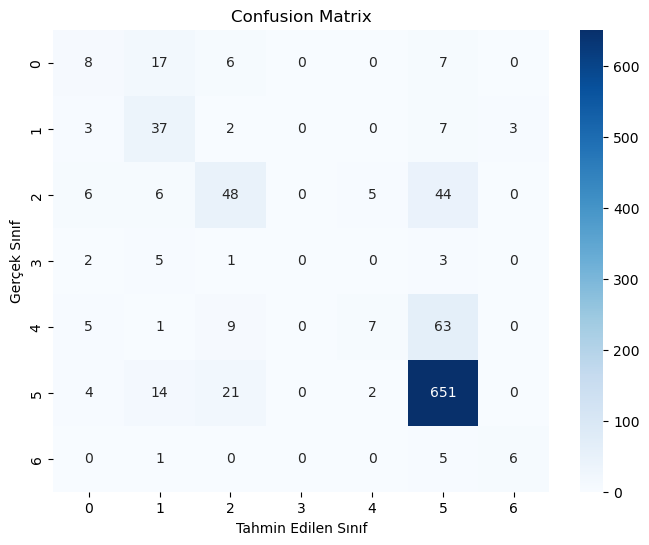

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('Confusion Matrix')
plt.show()


In [29]:
train_losses = []
val_accuracies = []

num_epochs = 5  

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    val_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


Epoch 1/5, Loss: 0.5359, Accuracy: 0.7954
Epoch 2/5, Loss: 0.5100, Accuracy: 0.8069
Epoch 3/5, Loss: 0.5082, Accuracy: 0.8099
Epoch 4/5, Loss: 0.4813, Accuracy: 0.8182
Epoch 5/5, Loss: 0.4549, Accuracy: 0.8296


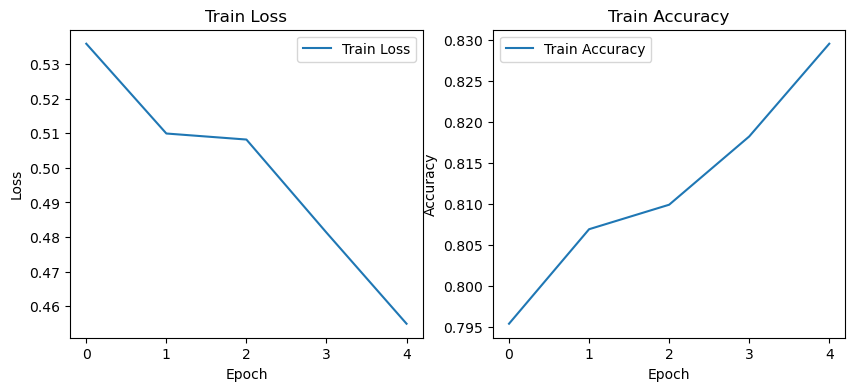

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train Accuracy')
plt.legend()

plt.show()
